In [2]:
import pandas as pd
import numpy as np
import joblib

In [3]:
df = pd.read_csv('data/deptos_amba.csv')
df.drop(df[df['bathrooms'] > 7].index, inplace=True)
df = df[df['bedrooms'] <= df['rooms']]
df.drop(columns=['ogc_fid', 'price', 'surface_to', 'surface_co'], inplace=True)
df.dropna(inplace=True)

In [6]:
df.head()

,lat,lon,rooms,bedrooms,bathrooms,pm2
33,-34.633040,-58.370326,1.0,0.0,1.0,3035.714286
34,-34.463852,-58.900756,2.0,1.0,1.0,1547.619048
35,-34.641102,-58.790449,2.0,1.0,1.0,1536.585366
36,-34.641102,-58.790449,2.0,1.0,1.0,1536.585366
37,-34.553930,-58.459700,2.0,1.0,1.0,3700.000000


In [3]:
modelo_regresion = joblib.load('rk_model.pkl')

In [4]:
modelo_regresion = modelo_regresion.regression_model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.linear_model import ElasticNet

df = df.sample(10000, random_state=42)

latitudes = df['lat'].values
longitudes = df['lon'].values
pm2_values = df['pm2'].values
X = df[['rooms', 'bedrooms', 'bathrooms']].values
y = df['pm2'].values

modelo = ElasticNet(alpha=1, l1_ratio=0.5)
modelo.fit(X, y)
predictions = modelo.predict(X)
residuals = y - predictions

coords = np.column_stack((latitudes, longitudes))

distances = cdist(coords, coords)

diffs = (residuals[:, np.newaxis] - residuals[np.newaxis, :]) ** 2

lag_width = 0.01  # en grados
max_distance = 1.0
bins = np.arange(0, max_distance + lag_width, lag_width)
bin_centers = (bins[:-1] + bins[1:]) / 2

semivariances = []
for i in range(len(bins) - 1):
    mask = (distances >= bins[i]) & (distances < bins[i + 1])
    if np.any(mask):
        semivariances.append(np.mean(diffs[mask]) / 2)
    else:
        semivariances.append(None)

semivariances = np.array(semivariances)

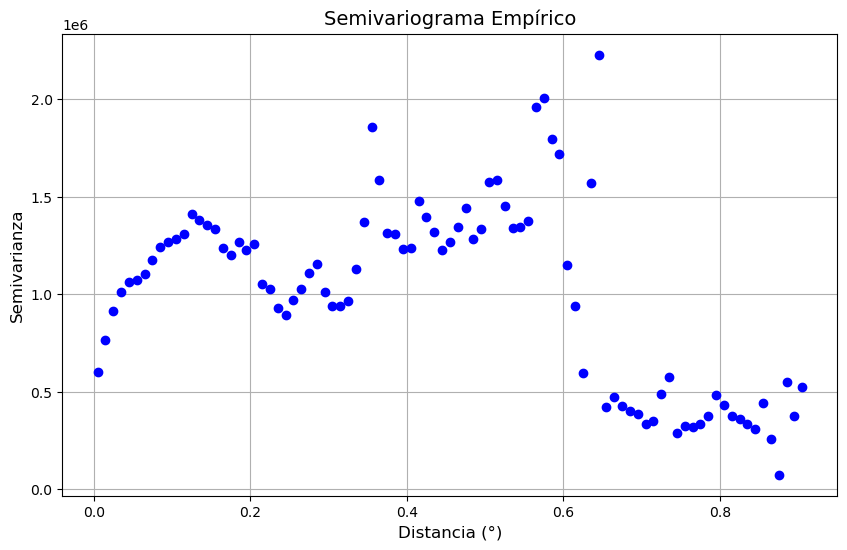

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(bin_centers, semivariances, 'o', color='b')
plt.xlabel("Distancia (°)", fontsize=12)
plt.ylabel("Semivarianza", fontsize=12)
plt.title("Semivariograma Empírico", fontsize=14)
plt.grid()
plt.savefig('plots/semivariograma.png')
plt.show()